In [44]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_result(path):
    buffer_dist = []
    statistic = []
    buffers = []
    segments = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("[TIME]")):
                statistic.append(line.strip("[TIME]").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffers.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            elif (line.startswith("[#segments]")):
                segments.append(line.strip("[#segments]").strip("\n"))
            else:
                buffer_dist.append(line.strip("\n").split(","))

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffers):
        buffers = np.array(buffers)
        buffers = pd.DataFrame(buffers, columns=['CCEH0_buffers', 'CCEH1_buffers'], dtype=np.float)
    if (segments):
        segments = np.array(segments)
        segments = pd.DataFrame(segments, columns=['#segments'], dtype=np.float)
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    for i in range(16):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    print("CCEH0 max runtime = ",max_size0)
    

    cceh0 = np.zeros(max_size0)
    
    for i in range(16):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    for i,v in enumerate(cceh0):
        if (i == 0):
            continue
        cceh0[i] += cceh0[i-1]
    
    return cceh0, segments

In [45]:
x0, y0 = get_result("../CCEH/discover_cceh/#segments_16th_1200m.txt")
x1, y1 = get_result("../release/#segments_16th_1200m.txt")

CCEH0 max runtime =  75
CCEH0 max runtime =  75


/tmp/ipykernel_6856/3775310726.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_6856/3775310726.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  segments = pd.DataFrame(segments, columns=['#segments']

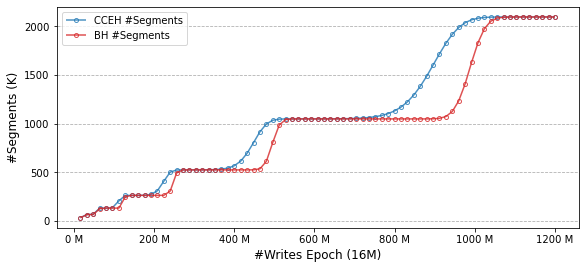

In [46]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
import matplotlib.ticker as mticker
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['CCEH #Segments', 'BH #Segments']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, (ax) = plt.subplots(figsize=(8, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax.plot(x0/1000000, y0/1000, color=colors[2], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(x1/1000000, y1/1000, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper left")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

ax.set_xlabel('#Writes Epoch (16M)', fontsize=12)
ax.set_ylabel('#Segments (K)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d M'))

# ax0.legend(loc="upper left")
# ax0.grid(which='major', linestyle='--', zorder=0)
# ax0.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
# ax0.xaxis.grid(False, which='both')

# ax0.set_xlabel('#Writes (8M)', fontsize=12)
# ax0.set_ylabel('#Segments', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("./discover_cceh/#segments_1200m.pdf", bbox_inches='tight', pad_inches=0)



## Throughput Graph (Use #Writes as X axis)

In [97]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_throughput_result(path):
    buffer_dist = []
    statistic = []
    buffers = []
    segments = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("[TIME]")):
                statistic.append(line.strip("[TIME]").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffers.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            elif (line.startswith("[#segments]")):
                segments.append(line.strip("[#segments]").strip("\n"))
            else:
                buffer_dist.append(line.strip("\n").split(","))

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffers):
        buffers = np.array(buffers)
        buffers = pd.DataFrame(buffers, columns=['CCEH0_buffers', 'CCEH1_buffers'], dtype=np.float)
    if (segments):
        segments = np.array(segments)
        segments = pd.DataFrame(segments, columns=['#segments'], dtype=np.float)
    
    
    elapse = []
    ops = []
    for i in range(1000000, 75000000, 1000000):
        ops.append(16*i)
        th = statistic[statistic["cur_done"]==i]
        elapse.append( 16000000/th['seg_time'].max()/1024/1024)
#     print(ops, elapse)

    return ops, elapse

In [98]:
x0, y0 = get_throughput_result("../CCEH/discover_cceh/throughput_16th_1200m.txt")
x1, y1 = get_throughput_result("../release/throughput_16th_1200m.txt")

/tmp/ipykernel_6856/527372025.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)


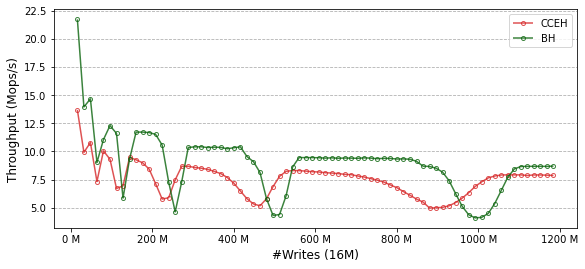

In [99]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['CCEH', 'BH']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(8, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax.plot(np.array(x0)/1000000, y0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(np.array(x1)/1000000, y1, color=colors[4], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

ax.set_xlabel('#Writes (16M)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d M'))


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("./discover_cceh/throughput_16th_1200m.pdf", bbox_inches='tight', pad_inches=0)




## #Segments and throughput Graph (Use wall time as X axis)

In [104]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_time_result(path):
    buffer_dist = []
    statistic = []
    buffers = []
    segments = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("[TIME]")):
                statistic.append(line.strip("[TIME]").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffers.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            elif (line.startswith("[#segments]")):
                segments.append(line.strip("[#segments]").strip("\n"))
            else:
                buffer_dist.append(line.strip("\n").split(","))

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffers):
        buffers = np.array(buffers)
        buffers = pd.DataFrame(buffers, columns=['CCEH0_buffers', 'CCEH1_buffers'], dtype=np.float)
    if (segments):
        segments = np.array(segments)
        segments = pd.DataFrame(segments, columns=['#segments'], dtype=np.float)
    
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    for i in range(16):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    print("CCEH0 max runtime = ",max_size0)
    
    cceh0 = np.zeros(max_size0)
    
    for i in range(16):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    x = [i for i in range(1, segments.shape[0] + 1)]
    return x, segments

In [105]:
x0, y0 = get_time_result("../CCEH/discover_cceh/#segments_16th_time_1200m.txt")

x1, y1 = get_time_result("../release/#segments_16th_time_1200m.txt")


CCEH0 max runtime =  160
CCEH0 max runtime =  134


/tmp/ipykernel_6856/251122987.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_6856/251122987.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  segments = pd.DataFrame(segments, columns=['#segments'], 

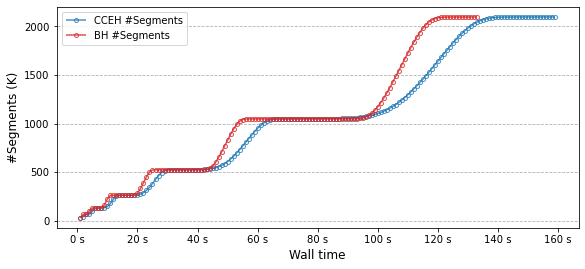

In [106]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
import matplotlib.ticker as mticker
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['CCEH #Segments', 'BH #Segments']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, (ax) = plt.subplots(figsize=(8, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax.plot(x0, y0/1000, color=colors[2], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(x1, y1/1000, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper left")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

ax.set_xlabel('Wall time', fontsize=12)
ax.set_ylabel('#Segments (K)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d s'))


fig.savefig("./discover_cceh/#segments_time_1200m.pdf", bbox_inches='tight', pad_inches=0)




In [112]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_time_result(path):
    buffer_dist = []
    statistic = []
    buffers = []
    segments = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("[TIME]")):
                statistic.append(line.strip("[TIME]").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffers.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            elif (line.startswith("[#segments]")):
                segments.append(line.strip("[#segments]").strip("\n"))
            else:
                buffer_dist.append(line.strip("\n").split(","))

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffers):
        buffers = np.array(buffers)
        buffers = pd.DataFrame(buffers, columns=['CCEH0_buffers', 'CCEH1_buffers'], dtype=np.float)
    if (segments):
        segments = np.array(segments)
        segments = pd.DataFrame(segments, columns=['#segments'], dtype=np.float)
    
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    for i in range(16):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    print("CCEH0 max runtime = ",max_size0)
    
    cceh0 = np.zeros(max_size0)
    
    for i in range(16):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    # the epoch is 1 second
    x = [i for i in range(1, len(cceh0) + 1)]
    y = cceh0/1/1024/1024
    return x[:-1], y[:-1]

In [115]:
x0, y0 = get_time_result("../CCEH/discover_cceh/throughput_16th_time_1200m.txt")

x1, y1 = get_time_result("../release/#segments_16th_time_1200m.txt")

x2, y2 = get_time_result("../release/#segments_16th_time_1200m_layback.txt")



CCEH0 max runtime =  157
CCEH0 max runtime =  134
CCEH0 max runtime =  137


/tmp/ipykernel_6856/3714959475.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_6856/3714959475.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  segments = pd.DataFrame(segments, columns=['#segments']

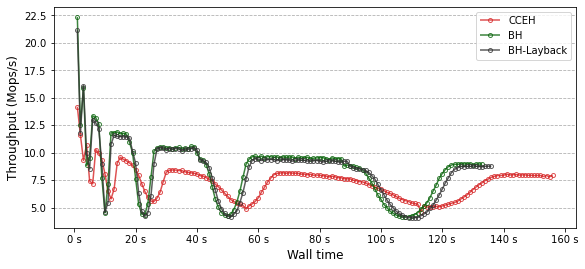

In [116]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['CCEH', 'BH', 'BH-Layback']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(8, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax.plot(np.array(x0), y0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(np.array(x1), y1, color=colors[4], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(np.array(x2), y2, color=colors[5], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

ax.set_xlabel('Wall time', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d s'))


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("./discover_cceh/throughput_16th_time_1200m_layback.pdf", bbox_inches='tight', pad_inches=0)
